Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.104128 s


'compile' took 1.508905 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.06e-02, 1.79e-01, 4.20e-02, 7.87e-01]    [1.10e-02, 1.79e-01, 4.20e-02, 7.87e-01]    []  
1000      [2.76e-02, 1.23e-04, 1.97e-01, 2.40e-01]    [3.21e-02, 1.23e-04, 1.97e-01, 2.40e-01]    []  
2000      [3.09e-02, 5.75e-03, 1.76e-01, 2.34e-01]    [3.52e-02, 5.75e-03, 1.76e-01, 2.34e-01]    []  
3000      [1.66e-02, 7.35e-03, 1.59e-01, 1.84e-01]    [1.65e-02, 7.35e-03, 1.59e-01, 1.84e-01]    []  
4000      [1.63e-02, 8.20e-03, 1.50e-01, 1.76e-01]    [1.60e-02, 8.20e-03, 1.50e-01, 1.76e-01]    []  
5000      [2.30e-02, 1.52e-02, 1.25e-01, 1.62e-01]    [2.06e-02, 1.52e-02, 1.25e-01, 1.62e-01]    []  
6000      [2.27e-02, 1.57e-02, 1.15e-01, 1.52e-01]    [

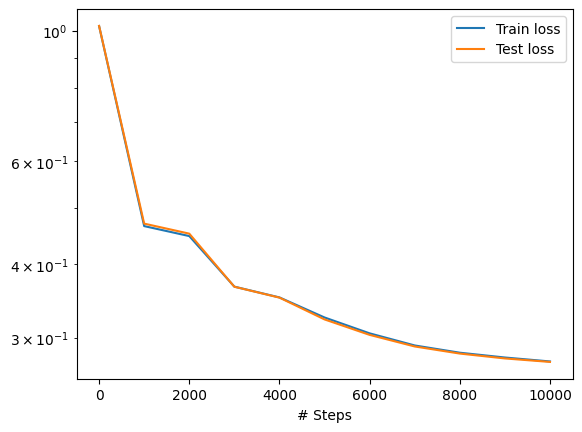

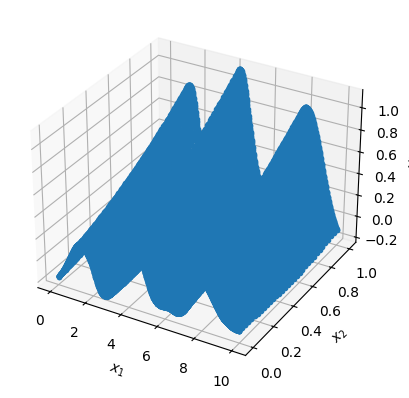

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np

v = 0.01
u = 1


def pde(x, y):
    e = x[:,0:1]
    n = x[:,1:2]
    f = y[:,0:1]
    f_e = dde.grad.jacobian(y, x, i=0, j=0)
    f_n = dde.grad.jacobian(y, x, i=0, j=1)
    f_ee = dde.grad.hessian(y, x, component=0, i=0, j=0)
    f_nn = dde.grad.hessian(y, x, component=0, i=0, j=1)
    f_nnn = dde.grad.jacobian(f_nn,x,i=0,j=1)
    f_ne = dde.grad.jacobian(f_n, x,i=0,j=1)
    beta = (v*e)/(3*u)
    
    eq = f_nnn + f*f_nn+beta*(1+f_n**2)-2*e*(f_n*f_ne-f_e*f_nn)
    return [eq]


# If n is equal to 1 (far boundary condition)
def bc1(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1.0)

# If n is equal to 0
def bc2(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0.0)


def f_n_equals_one(x):
    return np.ones_like(x[:, 0:1])  # Just return 1 for the boundary at n=1

def f_n_equals_zero(x):
    return np.zeros_like(x[:, 0:1])  # Just return 0 for the boundary at n=0

def f_equal_to_zero(x):
    return np.zeros_like(x[:, 0:1])  # Return 0 for the boundary at f=0

geom = dde.geometry.Rectangle([0,0],[10,1])

f_surface_boundary = dde.icbc.boundary_conditions.DirichletBC(geom,f_equal_to_zero,bc2, component=0)
f_n_surface_boundary = dde.icbc.boundary_conditions.NeumannBC(geom,f_n_equals_zero ,bc2 , component=0)
f_n_far_boundary = dde.icbc.boundary_conditions.NeumannBC(geom,f_n_equals_one ,bc1, component=0)


data = dde.data.PDE(
    geom,
    pde,
    [f_surface_boundary,f_n_surface_boundary,f_n_far_boundary],
    num_domain=10000,
    num_boundary=2000,
    num_test=10000,
)
layer_size = [2] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)